# Add all necessary libraries!

In [1]:
"""
@author: Sadman Sakib
"""

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import warnings
import os
import shutil
from PIL import ImageFile
warnings.simplefilter('error', Image.DecompressionBombWarning)
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 1000000000
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [2]:
# Make it False if do not intend to use Google Colab and want to train in local machine!!
google_colab_flag = False

# For training in Google Colab
if(google_colab_flag):
    from google.colab import drive
    drive.mount('/content/drive')
    !ls
    import sys
    # This is the path to where in google drive the code is stored!
    root_path = '/content/drive/My Drive/Practice/Stratified-k-fold-cross-validation-Image-classification-keras/'
    sys.path.append(root_path)

# For local training
else:
    root_path = ''

In [3]:
dataset_folder_name = os.path.join(root_path, 'DS')
source_files = []
class_labels = ['circles', 'squares', 'triangles'] # Change the class names according to your dataset. These names should be the same as the folder names inside train/test/validation
X = []
Y = []

img_rows, img_cols = 100, 100  # input image dimensions
train_path = os.path.join(dataset_folder_name, 'train')
validation_path = os.path.join(dataset_folder_name, 'validation')
test_path = os.path.join(dataset_folder_name, 'test')


In [4]:
def transfer_between_folders(source, dest, split_rate):
    """ Based on the split ratio this function moves some portion of the source folder to destination folder!

        Args:
            source: str
                Source folder's path
            dest: str
                Destination folder's path
            split_rate: float
                Ratio of files to move from source to dest locaiton

    """
    global source_files
    source_files = os.listdir(source)
    if(len(source_files) != 0):
        transfer_file_numbers = int(len(source_files)*split_rate)
        transfer_index = random.sample(
            range(0, len(source_files)), transfer_file_numbers)
        for each_index in transfer_index:
            shutil.move(os.path.join(source, str(source_files[each_index])), os.path.join(
                dest, str(source_files[each_index])))

    else:
        print("No file moved. Source empty!")


def transfer_all_class_between_folders(source, dest, split_rate):
    """ Transfer the files from source to dest for all the classes. This function calls the 'transfer_between_folders' to actually perform the transfer.

        Args:
            source: str
                Source folder's path
            dest: str
                Destination folder's path
            split_rate: float
                Ratio of files to move from source to dest locaiton

    """
    for label in class_labels:
        transfer_between_folders(os.path.join(dataset_folder_name, source, label),
                                 os.path.join(
                                     dataset_folder_name, dest, label),
                                 split_rate)


def my_metrics(y_true, y_pred):
    """ Calculate accuracy, precision, and f1 score of the model's prediction with respect to true labels.

        Args:
            y_true: list/array
                All true class labels
            y_pred: list/array
                All predicted class labels

        Returns:
            accuracy: float
                Accuracy measure of the model
            precision: float
                Precision measure of the model
            f1_Score: float
                F1-score measure of the model

    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    f1_Score = f1_score(y_true, y_pred, average='weighted')
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1_Score))
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1_Score


# First, check if test folder is empty or not, if not transfer all existing files to train.

In [5]:
transfer_all_class_between_folders('test', 'train', 1.0)


# Now, split some part of train data into the test folders.

In [6]:
transfer_all_class_between_folders('train', 'test', 0.20)


In [7]:
def prepare_name_with_labels(folder_name, dataset_type='train'):
    """ Prepare the file names (X) and the class labels (Y) from folder location of images.

        Args:
            folder_name: str
                Source folder's path

    """
    source_files = os.listdir(os.path.join(dataset_folder_name, dataset_type, folder_name))
    y_label = 0
    for i in range(len(class_labels)):
        if(folder_name == class_labels[i]):
            y_label = i
    for val in source_files:
        X.append(val)
        Y.append(y_label)



In [8]:
# Organize file names and class labels in X and Y variables
for i in range(len(class_labels)):
    prepare_name_with_labels(class_labels[i])


In [9]:
X = np.asarray(X)
Y = np.asarray(Y)


In [10]:
batch_size = 64
epoch = 10
num_of_channels = 3
number_of_class_labels = len(class_labels)

In [11]:
# This is Model 1. The model structure is very trivial, so feel free to optimize the structure of the model!

def get_model_1():
    activation_function = 'relu'

    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same',
                     activation=activation_function, input_shape=(img_rows, img_cols, num_of_channels)))
    model.add(Conv2D(64, (3, 3), activation=activation_function))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), padding='same',
                     activation=activation_function))
    model.add(Conv2D(32, (3, 3), activation=activation_function))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(16, (3, 3), padding='same',
                     activation=activation_function))
    model.add(Conv2D(16, (3, 3), activation=activation_function))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64, activation=activation_function))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation=activation_function))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation=activation_function))
    model.add(Dropout(0.1))
    model.add(Dense(number_of_class_labels, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


model_1 = get_model_1()



In [12]:
from tensorflow.keras.applications import Xception


def get_model_2():
    xception = Xception(include_top=False,
                        input_shape=(img_rows, img_cols, num_of_channels),
                        weights='imagenet')

    # trainable rnet
    xception.trainable = True
    model = tf.keras.Sequential([
        xception,
        GlobalAveragePooling2D(),
        Dense(100, activation='relu'),
        Dropout(0.1),
        Dense(50, activation='relu'),
        Dropout(0.1),
        Dense(number_of_class_labels, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model


model_2 = get_model_2()


In [13]:
from tensorflow.keras.applications import DenseNet201


def get_model_3():
    densenet = DenseNet201(
        input_shape=(img_rows, img_cols, num_of_channels),
        weights='imagenet',
        include_top=False
    )
    # trainable densenet
    densenet.trainable = True
    model = tf.keras.Sequential([
        densenet,
        GlobalAveragePooling2D(),
        Dense(number_of_class_labels, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


model_3 = get_model_3()


In [14]:
from tensorflow.keras.applications import VGG16


def get_model_4():
    vgg16 = VGG16(include_top=False,
                  input_shape=(img_rows, img_cols, num_of_channels),
                  weights='imagenet')

    # trainable rnet
    vgg16.trainable = True
    model = tf.keras.Sequential([
        vgg16,
        GlobalAveragePooling2D(),
        Dense(100, activation='relu'),
        Dropout(0.1),
        Dense(50, activation='relu'),
        Dropout(0.1),
        Dense(number_of_class_labels, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model


model_4 = get_model_4()


In [15]:
from tensorflow.keras.applications import InceptionResNetV2


def get_model_5():
    inception_rnet = InceptionResNetV2(include_top=False,
                        input_shape=(img_rows, img_cols, num_of_channels),
                        weights='imagenet')

    # trainable rnet
    inception_rnet.trainable = True
    model = tf.keras.Sequential([
        inception_rnet,
        GlobalAveragePooling2D(),
        Dense(100, activation='relu'),
        Dropout(0.1),
        Dense(50, activation='relu'),
        Dropout(0.1),
        Dense(number_of_class_labels, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model


model_5 = get_model_5()


# Stack all models

In [16]:
all_models = {
    'model_1': model_1,
    'model_2': model_2,
    'model_3': model_3,
    'model_4': model_4,
    'model_5': model_5,
}

# Create empty dict for storing model performance of K-fold-CV later
model_validation_performance_all_folds = dict()

for model_index in range(len(all_models)):
    model_validation_performance_all_folds['model_'+str(model_index+1)] = {'accuracy': [], 'precision': [], 'f1_score': []}
model_validation_performance_all_folds

{'model_1': {'accuracy': [], 'precision': [], 'f1_score': []},
 'model_2': {'accuracy': [], 'precision': [], 'f1_score': []},
 'model_3': {'accuracy': [], 'precision': [], 'f1_score': []},
 'model_4': {'accuracy': [], 'precision': [], 'f1_score': []},
 'model_5': {'accuracy': [], 'precision': [], 'f1_score': []}}

# **Stratified K-Fold Cross validation**

In [17]:
# ===============Stratified K-Fold======================
skf = StratifiedKFold(n_splits=3, shuffle=True)
skf.get_n_splits(X, Y)
fold_num = 0
for train_index, val_index in skf.split(X, Y):
    # First cut all images from validation to train (if any exists)
    transfer_all_class_between_folders('validation', 'train', 1.0)
    fold_num += 1
    print("Results for fold", fold_num)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    # Move validation images of this fold from train folder to the validation folder
    for each_index in range(len(X_val)):
        class_label = ''
        for i in range(len(class_labels)):
            if(Y_val[each_index] == i):
                class_label = class_labels[i]
        # Then, copy the validation images to the validation folder
        shutil.move(os.path.join(dataset_folder_name, 'train', class_label, X_val[each_index]),
                    os.path.join(dataset_folder_name, 'validation', class_label, X_val[each_index]))

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.20,
        fill_mode="nearest")
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Start ImageClassification Model
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')

    validation_generator = validation_datagen.flow_from_directory(
        validation_path,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode=None,  # only data, no labels
        shuffle=False)

    # Get true class labels of validation data
    true_classes = validation_generator.classes

    # Train all the models and save performance of each model on validation dataset
    for model_index in range(len(all_models)):
        # Fit model
        history = all_models['model_'+str(model_index+1)].fit(train_generator,
                            epochs=epoch)

        predictions = all_models['model_'+str(model_index+1)].predict(validation_generator, verbose=1)
        y_predictions = np.argmax(predictions, axis=1)

        # Evaluate validation performance
        print("***Performance on Validation data***")
        val_acc, val_prec, val_fScore = my_metrics(true_classes, y_predictions)

        model_validation_performance_all_folds['model_'+str(model_index+1)]['accuracy'].append(val_acc)
        model_validation_performance_all_folds['model_'+str(model_index+1)]['precision'].append(val_prec)
        model_validation_performance_all_folds['model_'+str(model_index+1)]['f1_score'].append(val_fScore)

Results for fold 1
Found 191 images belonging to 3 classes.
Found 64 images belonging to 3 classes.
Epoch 1/10
3/3 [==============================] - 6s 564ms/step - loss: 1.1070 - accuracy: 0.2984
Epoch 2/10
3/3 [==============================] - 0s 149ms/step - loss: 1.0955 - accuracy: 0.3874
Epoch 3/10
3/3 [==============================] - 0s 135ms/step - loss: 1.1017 - accuracy: 0.3298
Epoch 4/10
3/3 [==============================] - 0s 142ms/step - loss: 1.1025 - accuracy: 0.3089
Epoch 5/10
3/3 [==============================] - 0s 132ms/step - loss: 1.1054 - accuracy: 0.2670
Epoch 6/10
3/3 [==============================] - 0s 133ms/step - loss: 1.1015 - accuracy: 0.3037
Epoch 7/10
3/3 [==============================] - 0s 137ms/step - loss: 1.1010 - accuracy: 0.2827
Epoch 8/10
3/3 [==============================] - 0s 152ms/step - loss: 1.0997 - accuracy: 0.3403
Epoch 9/10
3/3 [==============================] - 1s 155ms/step - loss: 1.0983 - accuracy: 0.3822
Epoch 10/10
1/1 [=

c:\Users\sadma\anaconda3\envs\deeplearning\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 7s 731ms/step - loss: 1.0391 - accuracy: 0.5969
Epoch 2/10
3/3 [==============================] - 1s 144ms/step - loss: 0.5797 - accuracy: 0.8901
Epoch 3/10
3/3 [==============================] - 1s 157ms/step - loss: 0.4087 - accuracy: 0.9581
Epoch 4/10
3/3 [==============================] - 1s 153ms/step - loss: 0.4394 - accuracy: 0.9267
Epoch 5/10
3/3 [==============================] - 1s 146ms/step - loss: 0.2106 - accuracy: 0.9529
Epoch 6/10
3/3 [==============================] - 1s 144ms/step - loss: 0.1013 - accuracy: 0.9738
Epoch 7/10
3/3 [==============================] - 1s 148ms/step - loss: 0.0310 - accuracy: 0.9948
Epoch 8/10
3/3 [==============================] - 1s 152ms/step - loss: 0.0175 - accuracy: 1.0000
Epoch 9/10
3/3 [==============================] - 1s 143ms/step - loss: 0.0111 - accuracy: 0.9948
Epoch 10/10
1/1 [==============================] - 1s 585ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision :

c:\Users\sadma\anaconda3\envs\deeplearning\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
3/3 [==============================] - 7s 2s/step - loss: 2.1079 - accuracy: 0.2932
Epoch 2/10
3/3 [==============================] - 1s 141ms/step - loss: 1.3533 - accuracy: 0.3613
Epoch 3/10
3/3 [==============================] - 1s 142ms/step - loss: 1.1082 - accuracy: 0.3194
Epoch 4/10
3/3 [==============================] - 1s 150ms/step - loss: 1.1088 - accuracy: 0.3298
Epoch 5/10
3/3 [==============================] - 1s 139ms/step - loss: 1.1167 - accuracy: 0.2880
Epoch 6/10
3/3 [==============================] - 1s 147ms/step - loss: 1.1086 - accuracy: 0.3089
Epoch 7/10
3/3 [==============================] - 1s 140ms/step - loss: 1.1004 - accuracy: 0.3455
Epoch 8/10
3/3 [==============================] - 1s 142ms/step - loss: 1.1075 - accuracy: 0.3403
Epoch 9/10
3/3 [==============================] - 1s 158ms/step - loss: 1.1156 - accuracy: 0.3560
Epoch 10/10
1/1 [==============================] - 0s 164ms/step
***Performance on Validation data***
Accuracy  : 0.32812

c:\Users\sadma\anaconda3\envs\deeplearning\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
3/3 [==============================] - 18s 1s/step - loss: 0.8798 - accuracy: 0.6073
Epoch 2/10
3/3 [==============================] - 1s 230ms/step - loss: 0.2458 - accuracy: 0.9162
Epoch 3/10
3/3 [==============================] - 1s 210ms/step - loss: 0.1521 - accuracy: 0.9581
Epoch 4/10
3/3 [==============================] - 1s 214ms/step - loss: 0.1335 - accuracy: 0.9791
Epoch 5/10
3/3 [==============================] - 1s 213ms/step - loss: 0.0306 - accuracy: 0.9843
Epoch 6/10
3/3 [==============================] - 1s 211ms/step - loss: 0.0137 - accuracy: 0.9895
Epoch 7/10
3/3 [==============================] - 1s 205ms/step - loss: 0.0376 - accuracy: 0.9895
Epoch 8/10
3/3 [==============================] - 1s 218ms/step - loss: 0.0320 - accuracy: 0.9948
Epoch 9/10
3/3 [==============================] - 1s 201ms/step - loss: 0.0837 - accuracy: 0.9843
Epoch 10/10
1/1 [==============================] - 3s 3s/step
***Performance on Validation data***
Accuracy  : 0.328125


c:\Users\sadma\anaconda3\envs\deeplearning\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
3/3 [==============================] - 1s 148ms/step - loss: 1.0978 - accuracy: 0.3874
Epoch 2/10
3/3 [==============================] - 1s 143ms/step - loss: 1.0976 - accuracy: 0.3508
Epoch 3/10
3/3 [==============================] - 0s 152ms/step - loss: 1.0982 - accuracy: 0.3560
Epoch 4/10
3/3 [==============================] - 1s 158ms/step - loss: 1.0968 - accuracy: 0.3403
Epoch 5/10
3/3 [==============================] - 0s 154ms/step - loss: 1.0981 - accuracy: 0.3298
Epoch 6/10
3/3 [==============================] - 0s 149ms/step - loss: 1.0980 - accuracy: 0.3455
Epoch 7/10
3/3 [==============================] - 0s 144ms/step - loss: 1.0983 - accuracy: 0.3037
Epoch 8/10
3/3 [==============================] - 0s 149ms/step - loss: 1.0975 - accuracy: 0.3089
Epoch 9/10
3/3 [==============================] - 1s 157ms/step - loss: 1.0973 - accuracy: 0.3613
Epoch 10/10
1/1 [==============================] - 0s 52ms/step
***Performance on Validation data***
Accuracy  : 0.328

c:\Users\sadma\anaconda3\envs\deeplearning\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 1s 157ms/step - loss: 0.0418 - accuracy: 0.9791
Epoch 2/10
3/3 [==============================] - 1s 154ms/step - loss: 0.0120 - accuracy: 0.9948
Epoch 3/10
3/3 [==============================] - 1s 149ms/step - loss: 0.0787 - accuracy: 0.9791
Epoch 4/10
3/3 [==============================] - 1s 149ms/step - loss: 0.1577 - accuracy: 0.9895
Epoch 5/10
3/3 [==============================] - 1s 146ms/step - loss: 0.2042 - accuracy: 0.9791
Epoch 6/10
3/3 [==============================] - 1s 158ms/step - loss: 0.1824 - accuracy: 0.9634
Epoch 7/10
3/3 [==============================] - 1s 148ms/step - loss: 0.0654 - accuracy: 0.9895
Epoch 8/10
3/3 [==============================] - 1s 159ms/step - loss: 0.0460 - accuracy: 0.9843
Epoch 9/10
3/3 [==============================] - 1s 153ms/step - loss: 0.0227 - accuracy: 0.9948
Epoch 10/10
1/1 [==============================] - 0s 65ms/step
***Performance on Validation data***
Accuracy  : 0.6875
Precision

c:\Users\sadma\anaconda3\envs\deeplearning\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
3/3 [==============================] - 1s 222ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 2/10
3/3 [==============================] - 1s 213ms/step - loss: 0.0562 - accuracy: 0.9895
Epoch 3/10
3/3 [==============================] - 1s 215ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 4/10
3/3 [==============================] - 1s 234ms/step - loss: 0.1605 - accuracy: 0.9895
Epoch 5/10
3/3 [==============================] - 1s 216ms/step - loss: 0.0121 - accuracy: 0.9948
Epoch 6/10
3/3 [==============================] - 1s 208ms/step - loss: 0.1571 - accuracy: 0.9634
Epoch 7/10
3/3 [==============================] - 1s 209ms/step - loss: 0.0523 - accuracy: 0.9843
Epoch 8/10
3/3 [==============================] - 1s 210ms/step - loss: 0.0954 - accuracy: 0.9948
Epoch 9/10
3/3 [==============================] - 1s 224ms/step - loss: 0.0157 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 109ms/step
***Performance on Validation data***
Accuracy  : 0.32

c:\Users\sadma\anaconda3\envs\deeplearning\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 63 images belonging to 3 classes.
Epoch 1/10
3/3 [==============================] - 1s 172ms/step - loss: 1.1027 - accuracy: 0.3073
Epoch 2/10
3/3 [==============================] - 1s 156ms/step - loss: 1.1037 - accuracy: 0.2760
Epoch 3/10
3/3 [==============================] - 1s 162ms/step - loss: 1.0992 - accuracy: 0.3594
Epoch 4/10
3/3 [==============================] - 1s 177ms/step - loss: 1.0984 - accuracy: 0.3385
Epoch 5/10
3/3 [==============================] - 1s 148ms/step - loss: 1.0985 - accuracy: 0.3438
Epoch 6/10
3/3 [==============================] - 0s 149ms/step - loss: 1.0983 - accuracy: 0.3542
Epoch 7/10
3/3 [==============================] - 0s 152ms/step - loss: 1.0988 - accuracy: 0.3646
Epoch 8/10
3/3 [==============================] - 0s 147ms/step - loss: 1.0984 - accuracy: 0.3490
Epoch 9/10
3/3 [==============================] - 1s 162ms/step - loss: 1.0988 - accuracy: 0.2917
Epoch 10/10
1/1 [==============================] - 0s 52ms/step
***Performance

c:\Users\sadma\anaconda3\envs\deeplearning\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
3/3 [==============================] - 1s 153ms/step - loss: 0.0570 - accuracy: 0.9844
Epoch 2/10
3/3 [==============================] - 1s 161ms/step - loss: 0.0388 - accuracy: 0.9896
Epoch 3/10
3/3 [==============================] - 1s 165ms/step - loss: 0.0462 - accuracy: 0.9792
Epoch 4/10
3/3 [==============================] - 1s 158ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - 1s 159ms/step - loss: 0.1303 - accuracy: 0.9896
Epoch 6/10
3/3 [==============================] - 1s 169ms/step - loss: 0.0099 - accuracy: 0.9948
Epoch 7/10
3/3 [==============================] - 1s 162ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 8/10
3/3 [==============================] - 1s 166ms/step - loss: 0.0428 - accuracy: 0.9896
Epoch 9/10
3/3 [==============================] - 1s 153ms/step - loss: 0.0074 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 61ms/step
***Performance on Validation data***
Accuracy  : 0.936

# Check performance of all models for all folds

In [18]:
model_validation_performance_all_folds

{'model_1': {'accuracy': [0.328125, 0.328125, 0.3333333333333333],
  'precision': [0.107666015625, 0.107666015625, 0.1111111111111111],
  'f1_score': [0.16213235294117648, 0.16213235294117648, 0.16666666666666666]},
 'model_2': {'accuracy': [1.0, 0.6875, 0.9365079365079365],
  'precision': [1.0, 0.8186663879598661, 0.9431818181818182],
  'f1_score': [1.0, 0.6075860507246377, 0.9349381204950361]},
 'model_3': {'accuracy': [0.609375, 0.71875, 1.0],
  'precision': [0.40842056650246306, 0.8040364583333333, 1.0],
  'f1_score': [0.48847587719298247, 0.6620656992487772, 1.0]},
 'model_4': {'accuracy': [0.328125, 0.421875, 0.6349206349206349],
  'precision': [0.107666015625, 0.3267857142857143, 0.8119135046919624],
  'f1_score': [0.16213235294117648, 0.3359797297297298, 0.5490530303030303]},
 'model_5': {'accuracy': [0.328125, 0.328125, 0.8412698412698413],
  'precision': [0.107666015625, 0.107666015625, 0.8814814814814814],
  'f1_score': [0.16213235294117648, 0.16213235294117648, 0.8428858722

In [19]:
# Aggregate all models' peformance measures for k folds
for model_index in range(len(all_models)):
    model_validation_performance_all_folds['model_'+str(model_index+1)]['accuracy'] = np.mean(model_validation_performance_all_folds['model_'+str(model_index+1)]['accuracy'])
    model_validation_performance_all_folds['model_'+str(model_index+1)]['precision'] = np.mean(model_validation_performance_all_folds['model_'+str(model_index+1)]['precision'])
    model_validation_performance_all_folds['model_'+str(model_index+1)]['f1_score'] = np.mean(model_validation_performance_all_folds['model_'+str(model_index+1)]['f1_score'])

model_validation_performance_all_folds

{'model_1': {'accuracy': 0.3298611111111111,
  'precision': 0.10881438078703703,
  'f1_score': 0.1636437908496732},
 'model_2': {'accuracy': 0.8746693121693122,
  'precision': 0.9206160687138948,
  'f1_score': 0.8475080570732246},
 'model_3': {'accuracy': 0.7760416666666666,
  'precision': 0.7374856749452654,
  'f1_score': 0.7168471921472532},
 'model_4': {'accuracy': 0.46164021164021163,
  'precision': 0.4154550782008923,
  'f1_score': 0.34905503765797885},
 'model_5': {'accuracy': 0.49917328042328046,
  'precision': 0.3656045042438271,
  'f1_score': 0.38905019272666336}}

In [20]:
# Convert the dict to a datafrmae
import pandas as pd
all_model_performance_df = pd.DataFrame(model_validation_performance_all_folds)
all_model_performance_df

,model_1,model_2,model_3,model_4,model_5
accuracy,0.329861,0.874669,0.776042,0.461640,0.499173
precision,0.108814,0.920616,0.737486,0.415455,0.365605
f1_score,0.163644,0.847508,0.716847,0.349055,0.389050


Text(0, 0.5, 'Performance measure')

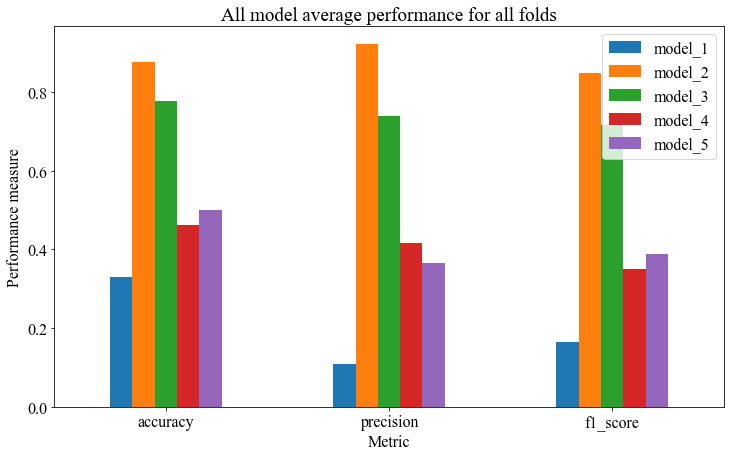

In [21]:
# Plot the performance values in bar chart
from matplotlib import pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"
plt.rcParams["figure.figsize"] = (12,7)

all_model_performance_df.plot.bar(rot=0)
plt.title('All model average performance for all folds', )
plt.xlabel("Metric")
plt.ylabel("Performance measure")


# Pick best models as the final models 

In [22]:
# The top N models to use in the final ensemble. This value should be less than the number of total models used (e.g., 5)
best_n = 3 # Here, we are picking the top 3 models out of 5 models. This value can be changed depnding on how many models you want to keep!
target_performance_metric = 'f1_score' # This can be changed to accuracy or precision also, depending on the goal of the task!
best_n_models = all_model_performance_df.loc[target_performance_metric].sort_values(ascending=False)[:best_n]
print(best_n_models) # Printing the best models' performance values (i.e., f1_score)
print("*** The best", best_n, "models ***")
best_n_models = list(best_n_models.index)
print(best_n_models) # Printing the names of the top models

model_2    0.847508
model_3    0.716847
model_5    0.389050
Name: f1_score, dtype: float64
*** The best 3 models ***
['model_2', 'model_3', 'model_5']


# Test phase

In [23]:
print("============= TEST RESULTS ============")
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False 
)
true_classes = test_generator.classes
best_n_model_y_preds = []

# Get the predictions of each model and check individual model's performance
for model in best_n_models:
    print(model)
    predictions = all_models[model].predict(test_generator, verbose=1)
    best_n_model_y_preds.append(predictions)
    y_predictions = np.argmax(predictions, axis=1)
    my_metrics(true_classes, y_predictions)
    
# Use the soft voting ensemble technique (by taking the average of the model's predicted probability)
y_predicted_probabilites_ensemble = np.mean(best_n_model_y_preds, axis=0) 
y_predictions_ensemble = np.argmax(y_predicted_probabilites_ensemble, axis=1)
print('*** Ensemble soft voting performance ***')
test_acc, test_prec, test_fScore = my_metrics(true_classes, y_predictions_ensemble)


============= TEST RESULTS ============
Found 45 images belonging to 3 classes.
model_2
1/1 [==============================] - 0s 471ms/step
Accuracy  : 0.9777777777777777
Precision : 0.9791666666666666
f1Score : 0.9777530589543938
[[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]
model_3
1/1 [==============================] - 2s 2s/step
Accuracy  : 0.9777777777777777
Precision : 0.9791666666666666
f1Score : 0.9777530589543938
[[15  0  0]
 [ 0 15  0]
 [ 1  0 14]]
model_5
1/1 [==============================] - 1s 809ms/step
Accuracy  : 0.9111111111111111
Precision : 0.9163398692810457
f1Score : 0.9109126984126985
[[13  2  0]
 [ 0 13  2]
 [ 0  0 15]]
*** Ensemble soft voting performance ***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[15  0  0]
 [ 0 15  0]
 [ 0  0 15]]
